In [ ]:
# default_exp engine.microscope

In [ ]:
%load_ext autoreload
%autoreload 2

# Microscope model

> Definition of the classes and modules we use to simulate recordings given network outputs

In [ ]:
#export
from decode_fish.imports import *
import torch.nn as nn
from torch.jit import script
from typing import Union, List
import torch.nn.functional as F

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
#export
class Microscope(nn.Module):
    """
    Mircoscope module takes  4 volumes 'locations', 'x_os_3d', 'y_os_3d', 'z_os_3d',
    'ints_3d'  and applies point spread function:
    1) Extracts values of intensities and offsets of given emitters
    2) Applies parametric PSF if given
    3) Applies empirical  PSF if given
    4) Combine all PSF and multiply by intenseties
    5) Normalize PSFs
    6) Places point spread function on to sampled locations  to
    generate 'x_sim' simulated image
    7) Multiplies x_sim by multipl


    Args:
        parametric_psf (torch.nn.Module): List of Paramateric PSF
        empirical_psf (torch.nn.Module): List of Emperical PSF
        noise (torch.nn.Module): Camera noise model
        scale(float): Paramter for scaling point spread functions
        multipl(float): Multiplication value that will be applied to xsim 
    Shape:
        -Input: locations: Tuple(BS, Frames, H, W, D)
                x_os_val: (N_emitters,)
                y_os_val: (N_emitters,)
                z_os_val: (N_emitters,)
                ints_val: (N_emitters,)
                output_shape: Shape Tuple(BS, Frames, H, W, D)

        -Output: xsim:    (BS, C, H, W, D)
    """


    def __init__(self,
                 parametric_psf: List[torch.nn.Module]=None,
                 empirical_psf : List[torch.nn.Module]=None ,
                 noise: Union[torch.nn.Module, None]=None,
                 scale: float = 10000., multipl=100,
                 psf_noise=None, clamp_mode = 'cp'
                 ):

        super().__init__()
        self.parametric_psf = parametric_psf if parametric_psf else None
        self.empirical_psf  = empirical_psf if empirical_psf else None
#         self.scale = torch.nn.Parameter(torch.tensor(scale))
        self.scale = scale
        self.noise = noise
        self.multipl = multipl
        self.psf_noise = psf_noise
        self.clamp_mode = clamp_mode
        
    def add_psf_noise(self, psf_stack):
        
        noise = torch.distributions.Normal(loc=0, scale=self.psf_noise).sample(psf_stack.shape).to(psf_stack.device)
        return psf_stack + noise
        
    def forward(self, locations, x_os_val, y_os_val, z_os_val, i_val,output_shape, bg=None, eval_=None, scale_x=None, scale_y=None, scale_z=None):
        
        if len(locations[0]):
        
            if scale_x: x_os_val = x_os_val*scale_x
            if scale_y: y_os_val = y_os_val*scale_y
            if scale_z: z_os_val = z_os_val*scale_z

            psf = 0
            if self.parametric_psf:
                for param_psf_ in self.parametric_psf:
                    psf += param_psf_(x_os_val, y_os_val, z_os_val)

            if self.empirical_psf:
                for emper_psf in self.empirical_psf:
                    psf += emper_psf(x_os_val, y_os_val, z_os_val)
                    
            if self.clamp_mode == 'cp':
                torch.clamp_min_(psf,0)
            #normalizing psf
#             psf_sum = psf.sum(dim=[2, 3, 4], keepdim=True)
#             psf_sum = torch.nn.ReLU().forward(psf).sum(dim=[2, 3, 4], keepdim=True)
#             psf = psf.div(psf_sum)
            if self.psf_noise: psf = self.add_psf_noise(psf)
            #applying intenseties (N_Emitters, C, H, W, D)

            psf = psf * i_val[:,None,None,None,None]
            xsim = place_psf(locations, psf, output_shape)
            xsim = self.scale * xsim * self.multipl
            if self.clamp_mode == 'cx':
                torch.clamp_min_(xsim,0)
            if eval_:
                return xsim, psf
            return xsim
        
        else:
            
            return torch.zeros(output_shape).cuda()

In [ ]:
#export
def place_psf(locations, psf_volume, output_shape):
    """
    Places point spread functions (psf_volume) in to corresponding locations.

    Args:
        locations: torch.Tensor
        psf_volume: torch.Tensor
        output_shape: torch.Tensor

    Shape:
        -Input: locations: Tuple(BS, Frames, H, W, D)
                psf: (Num_E, C, PSF_SZ_X, PSF_SZ_Y, PSF_SZ_Z) [
                Num_E-Number of Emitters, PSF_SZ_{X, Y, Z} - PSF filter size]
                output_shape: shape of the output volume (BS, Frames, H, W, D)
        -Output: placed_psf: (BS, Frames, H, W, D)

    Returns:
        placed_psf
    """
    filter_size = psf_volume.shape[2:]
    filter_sizes = torch.cat(
        [torch.tensor((sz // 2, sz // 2 + 1)) for sz in filter_size]).reshape(
        3, 2).cuda()
    padding_sz = torch.tensor(max(filter_size) // 2 + 2).cuda()
    batch, frame, h, w, d = locations
    placed_psf = _place_psf(psf_volume, padding_sz, filter_sizes, batch, frame, h, w, d, torch.tensor(output_shape))
    assert placed_psf.shape == output_shape
    return placed_psf

In [ ]:
#export
@script
def _place_psf(volume, pad_size, fz, b, c, h, w, d, output_shape):
    '''jit function for placing point spread function 
    1) This function will add padding to coordinates (h, w, d) (we need padding in order to place psf on the edges)
    afterwards we will just crop out to original shape
    2) Create empty tensor with paddings loc3d_like
    3) place each individual PSFs in to the coresponding cordinates in loc3d_like
    4) unpad to original output shape


    Args:
        volume:   torch.Tensor
        pad_size: torch.Tensor
        fs:       torch.Tensor
        b:        torch.Tensor
        c:        torch.Tensor
        h:        torch.Tensor
        w:        torch.Tensor
        d:        torch.Tensor
        szs:      torch.Tensor
        
    Shape:
        volume: (Num_E, C, PSF_SZ_X, PSF_SZ_Y, PSF_SZ_Z)
        pad_size: (1,)
        fs: (3, 2)
        b:  (Num_E,)
        c:  (Num_E,)
        h:  (Num_E,)
        w:  (Num_E,)
        d:  (Num_E,)
        output_shape:  (BS, Frames, H, W, D)
        
    -Output: placed_psf: (BS, Frames, H, W, D)
        
    '''
    #adding padding to h, w, d 
    h = h + pad_size
    w = w + pad_size
    d = d + pad_size

    #create padded tensor (bs, frame, c, h, w) We will need pad_size * 2 since we are padding from both size
    loc3d_like = torch.zeros(output_shape[0], 
                             output_shape[1], 
                             output_shape[2] + pad_size *2, 
                             output_shape[3] + pad_size *2, 
                             output_shape[4] + pad_size *2)
    loc3d_like = loc3d_like.to(d.device)
    psf_b, psf_c, psf_h, psf_w, psf_d = volume.shape
    volume = volume.reshape(-1, psf_h, psf_w, psf_d)

    for idx in range(b.shape[0]):
        loc3d_like[b[idx], c[idx],
        h[idx] - fz[0][0]:h[idx] + fz[0][1],
        w[idx] - fz[1][0]:w[idx] + fz[1][1],
        d[idx] - fz[2][0]:d[idx] + fz[2][1]] += volume[idx]

    b_sz, ch_sz, h_sz, w_sz, d_sz = loc3d_like.shape

    # unpad to original size
    placed_psf = loc3d_like[:, :, pad_size: h_sz - pad_size,
                                  pad_size: w_sz - pad_size,
                                  pad_size: d_sz - pad_size]
    return placed_psf

In [ ]:
#export 
def extractvalues( locs: torch.tensor,
                    x_os: torch.tensor,
                    y_os: torch.tensor,
                    z_os: torch.tensor,
                    ints:torch.tensor, dim: int=3):
    """
    Extracts Values of intensities and offsets of given emitters

     This function will take `locs`, `x_os`, `y_os`, `z_os`, `ints` all of the shapes, 
     and will extract `coord` coordinate of locations where our emittors  are present. 
     This `coord` will be used to extract values of `x`, `y`, `z`,
     offsets and intensities - `i` where the emitter is present
     
    Args:
        locs: location
        x_os: X offset
        y_os: Y offset
        z_os: Z offset
        ints: Intenseties
        dim:  Dimension 2D or 3D

    Shape:
        -Input: locs_3d: (BS, C, H, W, D)
                x_os_3d: (BS, C, H, W, D)
                y_os_3d: (BS, C, H, W, D)
                z_os_3d: (BS, C, H, W, D)
                ints_3d: (BS, C, H, W, D)

        -Output: :
                x_os_val: (Num_E, 1, 1, 1, 1)
                y_os_val: (Num_E, 1, 1, 1, 1)
                z_os_val: (Num_E, 1, 1, 1, 1)
                ints_val: (Num_E, 1, 1, 1, 1)
    """
    
    dim = tuple([1 for i in range(dim)])
    coord = tuple(locs.nonzero().transpose(1,0))
    x_os_val = x_os[coord].reshape(-1, *dim)
    y_os_val = y_os[coord].reshape(-1, *dim)
    z_os_val = z_os[coord].reshape(-1, *dim)
    ints_val = ints[coord].reshape(-1, *dim)
    return  x_os_val, y_os_val, z_os_val, ints_val

In [ ]:
from decode_fish.engine.psf import LinearInterpolatedPSF
from decode_fish.engine.noise import sCMOS
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.plotting import plot_3d_projections

psf_state = torch.load('../data/N2_352_psf.pkl')
psf = LinearInterpolatedPSF(psf_state['psf_volume'].shape[-3:], upsample_factor= 1)
psf.load_state_dict(psf_state)

noise = sCMOS()

micro = Microscope(parametric_psf=[psf], noise=noise, multipl=10000, psf_noise=0.0001).cuda()

point_process = PointProcessUniform(local_rate = torch.ones([2,1,48,48,48]).cuda()*.0001, min_int = 0.5)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample()

array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

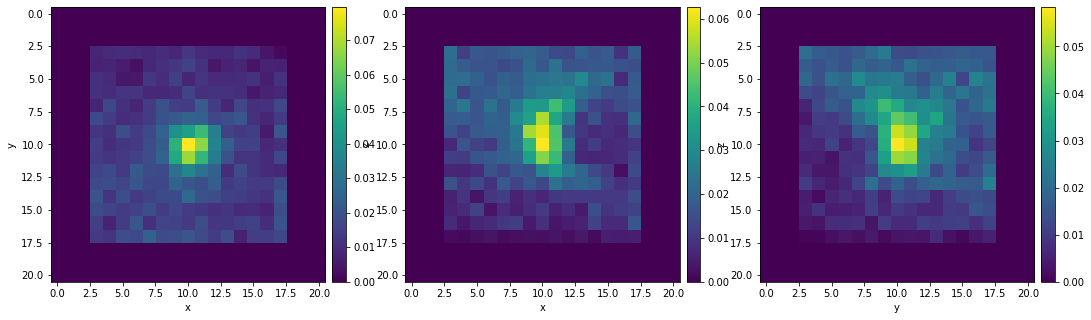

In [ ]:
plot_3d_projections(psf.psf_volume.cpu().detach().numpy()[0])

divpsf tensor(23.0333, device='cuda:0', grad_fn=<SumBackward0>)
psf*i tensor(17.0671, device='cuda:0', grad_fn=<SumBackward0>)
placepsf tensor(14.4521, device='cuda:0', grad_fn=<SumBackward0>)
scaled tensor(1.4452e+09, device='cuda:0', grad_fn=<SumBackward0>)
clamped tensor(1.4452e+09, device='cuda:0', grad_fn=<SumBackward0>)


array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

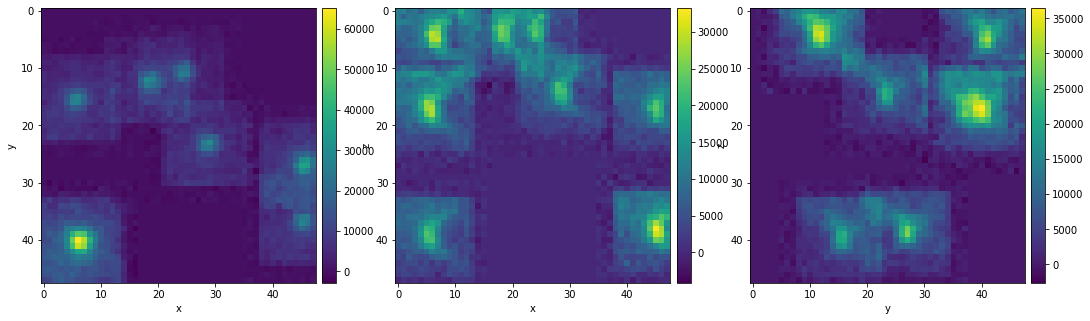

In [ ]:
xsim = micro(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape)
plot_3d_projections(xsim[0,0])

In [ ]:
from decode_fish.funcs.file_io import get_gaussian_psf
cfg = OmegaConf.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_352/sweep_b1/psf_noise:0xnum_iter:10000/train.yaml')
psf = get_gaussian_psf(cfg.microscope.psf_extent_zyx, cfg.PSF.gauss_radii)
# psf.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf.pkl'))
noise = hydra.utils.instantiate(cfg.noise)
micro = Microscope(parametric_psf=[psf], noise=noise, multipl=cfg.microscope.multipl, psf_noise=2e-3, clamp_mode=cfg.microscope.clamp_mode).cuda()

In [ ]:
get_gaussian_psf(cfg.microscope.psf_extent_zyx, cfg.PSF.gauss_radii).psf_volume.sum()/psf.psf_volume.sum()

tensor(1., grad_fn=<DivBackward0>)

divpsf tensor(22.7526, device='cuda:0', grad_fn=<SumBackward0>)
psf*i tensor(16.8434, device='cuda:0', grad_fn=<SumBackward0>)
placepsf tensor(16.6788, device='cuda:0', grad_fn=<SumBackward0>)
scaled tensor(6671519., device='cuda:0', grad_fn=<SumBackward0>)
clamped tensor(34994180., device='cuda:0', grad_fn=<SumBackward0>)
tensor(34994180., device='cuda:0', grad_fn=<SumBackward0>)


array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

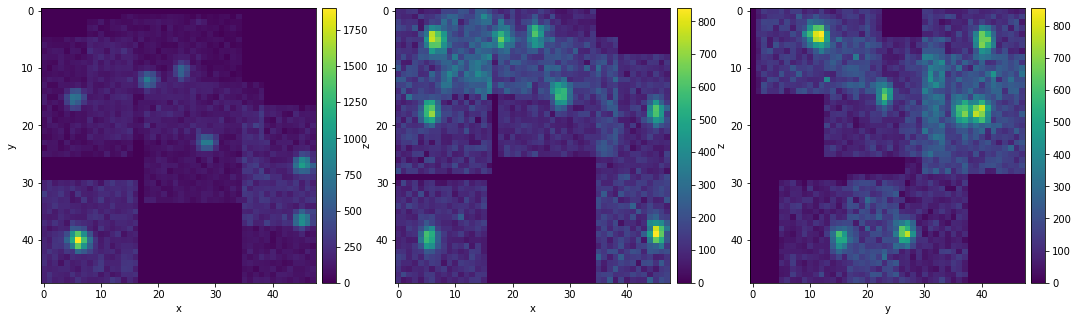

In [ ]:
xsim = micro(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape)
print(xsim.sum())
plot_3d_projections(xsim[0,0])

divpsf tensor(23.0567, device='cuda:0', grad_fn=<SumBackward0>)
psf*i tensor(17.0866, device='cuda:0', grad_fn=<SumBackward0>)
placepsf tensor(24.2850, device='cuda:0', grad_fn=<SumBackward0>)
scaled tensor(9713998., device='cuda:0', grad_fn=<SumBackward0>)
clamped tensor(23002324., device='cuda:0', grad_fn=<SumBackward0>)
tensor(23002324., device='cuda:0', grad_fn=<SumBackward0>)


array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

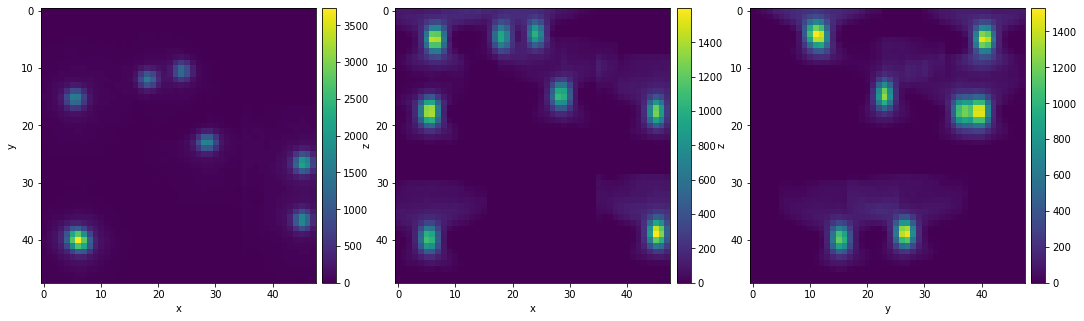

In [ ]:
xsim = micro(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape)
print(xsim.sum())
plot_3d_projections(xsim[0,0])

array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

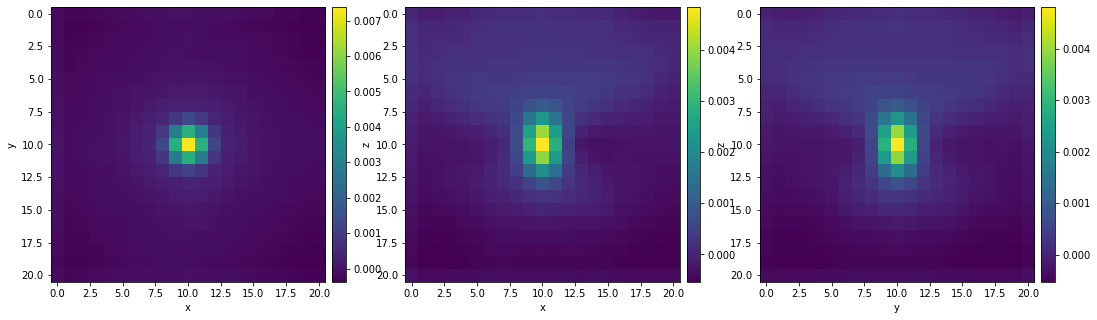

In [ ]:
plot_3d_projections(torch.clamp_min(psf.psf_volume[0],-5),'mean')

In [ ]:
from decode_fish.funcs.file_io import *
from decode_fish.funcs.output_trafo import *
cfg = OmegaConf.load(default_conf)
gt_img = load_tiff_image('/groups/turaga/home/speisera/share_TUM/FishSIM/sim_1/mRNAlevel_200/cell3D/strong/w1_HelaKyoto_Gapdh_2597_p01_cy3__Cell_CP_14__cell3D__1.tif')

In [ ]:
model_out = torch.load('../data/model_output.pt')
locs_ae, x_os_ae, y_os_ae, z_os_ae, ints_ae, output_shape_ae = model_output_to_micro_input(model_out, threshold=0.1)
ae_img = micro(locs_ae, x_os_ae, y_os_ae, z_os_ae, ints_ae, output_shape_ae)

In [ ]:
log_p_x_given_z = - micro.noise(ae_img,model_out['background']).log_prob(gt_img[None,:,30:].cuda()).mean()
log_p_x_given_z.backward()

In [ ]:
log_p_x_given_z

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted index.ipynb.
